# Evaluation for the second model

In [1]:
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import DataLoader

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


In [3]:
import sys; sys.path.insert(0, '/mnt/src')

## Read Datasets from .csv

In [4]:
from utils.file_io import read_trajectory_datasets

In [5]:
feature_columns = [
    'left_boom_base_yaw_joint', 
    'left_boom_base_pitch_joint',
    'left_boom_main_prismatic_joint',
    'left_boom_second_roll_joint',
    'left_boom_second_yaw_joint',
    'left_boom_top_pitch_joint',
    'left_boom_ee_joint',
    'cable1_property(length,youngsmodule(bend,twist))',
    'cable2_property(length,youngsmodule(bend,twist))',
    'cable3_property(length,youngsmodule(bend,twist))'
]

label_features = [
    ('cable1_lowest_point', np.array([1], dtype=np.int64)),
    ('cable2_lowest_point', np.array([1], dtype=np.int64)),
    ('cable3_lowest_point', np.array([1], dtype=np.int64))
]

normalized_features = [
    ('cable1_property(length,youngsmodule(bend,twist))', np.array([1,2], dtype=np.int64)),
    ('cable2_property(length,youngsmodule(bend,twist))', np.array([1,2], dtype=np.int64)),
    ('cable3_property(length,youngsmodule(bend,twist))', np.array([1,2], dtype=np.int64))
]

In [6]:
data_folder = Path("/mnt/data/")
train_set, test_set, validation_set, visualization_set = read_trajectory_datasets(data_folder, 0.8, 0.15, 0.045, 0.005, 64, 
                                                                                  feature_columns=feature_columns, label_features=label_features, normalized_features=normalized_features)

Reading .csv files: 1it [00:00,  1.50it/s]
/mnt/src/utils/preprocessing.py:132: RuntimeWarning: divide by zero encountered in divide
  return np.where(x_max != x_min, (features - x_min) / (x_max - x_min), 1).astype(dtype=np.float32)
/mnt/src/utils/preprocessing.py:132: RuntimeWarning: invalid value encountered in divide
  return np.where(x_max != x_min, (features - x_min) / (x_max - x_min), 1).astype(dtype=np.float32)


Preprocessing dataframe
Reshaping dataframe for learning


In [7]:
input_shape, output_shape = 16, 3
print(f"Data shape {input_shape} / {output_shape} of total {len(train_set) + len(validation_set) + len(test_set) + len(visualization_set)} data rows!")

Data shape 16 / 3 of total 1678 data rows!


## Load parameter, functions and dataloader

In [8]:
from utils.file_io import define_dataloader_from_subset
import os
import ast
from dotenv import load_dotenv

In [9]:
model_path = Path("/mnt/models/lstm/").absolute()

In [10]:
dotenv_path = model_path / ".env"
load_dotenv(dotenv_path=dotenv_path)

learning_rate = float(os.getenv("LEARNING_RATE"))
batch_size = int(os.getenv("BATCH_SIZE"))
optimizer = os.getenv("OPTIMIZER")
n_layers = int(os.getenv("N_LAYERS"))
hidden_layers_proj_size = ast.literal_eval(os.getenv("HIDDEN_LAYERS_PROJ_SIZE"))
lstm_dropout = float(os.getenv("LSTM_DROPOUT"))
final_dropout = float(os.getenv("FINAL_DROPOUT"))
num_epochs = 5

In [11]:
train_dataloader, validation_dataloader, test_dataloader = define_dataloader_from_subset(train_set, validation_set, test_set, batch_size=batch_size)

## Load and Train the model

In [12]:
from models.lstm import DecoderLSTM, train
from utils.loss_functions import get_loss_function
from utils.optimizer import get_optimizer_function
from utils.early_stopping import EarlyStopping

In [13]:
model = DecoderLSTM(input_shape, hidden_layers_proj_size[0], output_shape, lstm_dropout, 
                    final_dropout, n_layers, proj_size=hidden_layers_proj_size[1])
optimizer = get_optimizer_function(optimizer, model, learning_rate)
loss_function = get_loss_function()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.0668086520310816 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [14]:
early_stopping = EarlyStopping(10)

In [15]:
_ = train(num_epochs, train_dataloader, validation_dataloader, model, loss_function, optimizer, model_path, device, early_stopping=early_stopping)

Epoch: 1
Loss on train: 0, loss on validation: 16.394243240356445
Epoch: 2
Loss on train: 0, loss on validation: 15.448664665222168
Epoch: 3
Loss on train: 0, loss on validation: 14.329992294311523
Epoch: 4
Loss on train: 0, loss on validation: 13.303308486938477
Epoch: 5
Loss on train: 0, loss on validation: 12.498645782470703


## Evaluation

In [16]:
from utils.evaluation import compute_losses_from, compute_sliding_window_predictions
from utils.visualization import create_plot_for_dimensions

In [17]:
model_state_dict = torch.load(model_path / "checkpoint.pt")
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [18]:
model.eval()

DecoderLSTM(
  (lstm): LSTM(16, 5, dropout=0.0668086520310816)
  (final_dropout): Dropout(p=0.0973320690374255, inplace=False)
  (out): Linear(in_features=5, out_features=3, bias=True)
)

## 1. Analysis: Compute test loss

In [19]:
y, y_true = compute_sliding_window_predictions(test_dataloader, model, 'cpu')
test_losses = compute_losses_from(y, y_true, get_loss_function())
print(f"The mean squared error of the loaded model on test is: {test_losses.mean()}")

The mean squared error of the loaded model on test is: 15.007464408874512


## 2. Analysis: Show Cable lowest points

In [20]:
visualization_dataloader = DataLoader(visualization_set, batch_size=batch_size, shuffle=False)

In [21]:
y, y_true = compute_sliding_window_predictions(visualization_dataloader, model, 'cpu')

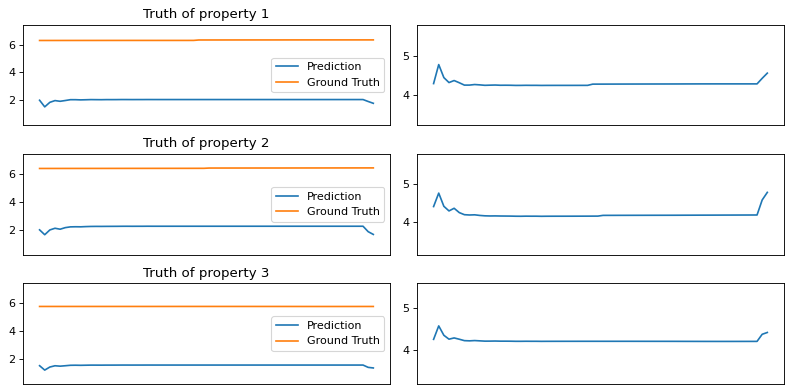

In [24]:
plot = create_plot_for_dimensions(y.numpy(), y_true.numpy(), size=4)
plot.show()

In [23]:
plot.savefig(model_path / "predictions.png")

<Figure size 640x480 with 0 Axes>